In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep as fallasleep
import os, sys

In [2]:
import krakenex
from pykrakenapi import KrakenAPI

In [3]:
color_box = ['#1f77b4','#ff7f0e','#2ca02c','#d62728',
             '#9467bd','#8c564b','#e377c2','#7f7f7f',
             '#bcdb22','#17becf']

In [4]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "BTC", "XRP", "ADA", "DOT"]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in enumerate(coins):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


In [5]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [6]:
df_close.isna().sum()

ETHUSD      0
BTCUSD      0
XRPUSD      0
ADAUSD      0
DOTUSD    269
dtype: int64

In [7]:
df_close = df_close.dropna()
df_close.isna().sum()

ETHUSD    0
BTCUSD    0
XRPUSD    0
ADAUSD    0
DOTUSD    0
dtype: int64

In [8]:
df_close.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-18,422.62,11957.0,0.30292,0.137218,3.1099
2020-08-19,407.57,11757.4,0.28992,0.129678,2.9175
2020-08-20,416.20,11864.6,0.29246,0.134305,2.9090


In [9]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,ETHUSD,BTCUSD,XRPUSD,ADAUSD,DOTUSD
dtime,,,,,
2020-08-19,-0.036261,-0.016834,-0.043864,-0.056516,-0.063863
2020-08-20,0.020953,0.009076,0.008723,0.035059,-0.002918
2020-08-21,-0.070599,-0.029240,-0.046364,-0.087043,0.056341


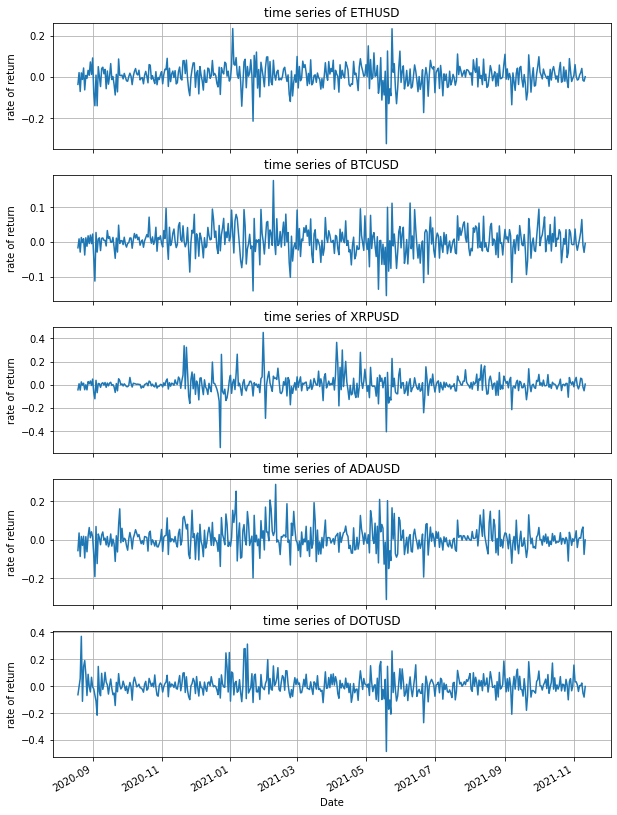

In [10]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

### Mean-Variance Optimization (with cardinality constraint) - BUY/NOT BUY
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} \lambda x^TQx - (1 - \lambda) r^Tx\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
        &&& \lambda \in [0,1]\\
\end{aligned}
$$

In [11]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

## Using Gurobi

In [12]:
from gurobipy import *

In [474]:
def obj_val(x):
    return 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)

def print_bold(string, end=False):
    if end:
        print('\033[91m' + '\033[1m' + string + '\033[0m',end="")
    else:
        
        print('\033[91m' + '\033[1m' + string + '\033[0m')

In [146]:
m   = Model("MVO")
x   = {}
n   = len(Q)
lam = 0.5
k   = 2
x   = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = 0.5 * lam * (x @ Q @ x) - (1 - lam) * (r @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
gurobi   = []
for v in m.getVars():
    gurobi.append(int(v.x))
    if v.x == 1:
        selected.append(v.VarName)
print(f"Gurobi selected:         {selected}")
print(f"Gurobi optimal solution: {gurobi}")
print(f"Gurobi optimal value:    {obj_val(gurobi)}")

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x96d6c486
Model has 15 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 3e-03]
  QObjective range [8e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective -0.0025598
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -3.414362e-03, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      -0.0026489   -0.00265  0.00%     -    0s

Explored 0 nodes (6 simplex iterati

## Using Qiskit

In [16]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import algorithm_globals

### Mean-Variance Optimization (with cardinality constraint), Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2} \lambda x^TQx - (1 - \lambda) r^Tx +  P \cdot (\mathbf{1}^Tx - k) \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [359]:
portfolio = PortfolioOptimization(expected_returns=(1-lam)*r, covariances=0.5*Q,
                                  risk_factor=lam, budget=k)
qp = portfolio.to_quadratic_program()
seed = 6969

### QAOA

In [360]:
def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(coins[i])
    return purchase

def index_to_selection(i, n):
    s = "{0:b}".format(i).rjust(n)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(n))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.6f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        if (x == selection).all():
            print_bold('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        else:
            print('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

In [361]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=2500)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

selection, state, values, probabilities = print_result(result)

print(f"QAOA selected:         {selection_to_picks(n, selection)}")
print(f"QAOA optimal solution: {selection}")
print(f"QAOA optimal value:    {obj_val(selection)}")

Optimal: selection [0. 1. 0. 1. 0.], value -0.002649

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1]	0.000150		0.100137
[1 0 1 0 0]	-0.000515		0.099838
[0 0 1 1 0]	-0.000388		0.099819
[0 1 1 0 0]	-0.000476		0.099691
[0 0 0 1 1]	-0.001905		0.099282
[1 0 0 0 1]	-0.001946		0.099265
[0 1 0 0 1]	-0.002032		0.099172
[1 0 0 1 0]	-0.002643		0.099017
[0 1 0 1 0]	-0.002649		0.098890
[1 1 0 0 0]	-0.002560		0.098817
[1 1 1 1 1]	9.268484		0.001937
[0 0 0 0 0]	4.117079		0.000656
[1 1 0 1 1]	4.117001		0.000348
[1 0 1 1 1]	4.120224		0.000346
[0 1 1 1 1]	4.119297		0.000336
[1 1 1 1 0]	4.118202		0.000336
[1 1 1 0 1]	4.119166		0.000336
[0 1 0 0 0]	1.027792		0.000335
[1 0 0 0 0]	1.027355		0.000311
[0 0 0 1 0]	1.027330		0.000309
[0 0 1 0 0]	1.029425		0.000306
[0 0 0 0 1]	1.027773		0.000299
[0 1 1 0 1]	1.029730		0.000023
[1 1 1 0 0]	1.028955		0.000023
[0 1 1 1 0]	1.029019		0.000023
[1 0 1 0 1]	1.030215		0.00002

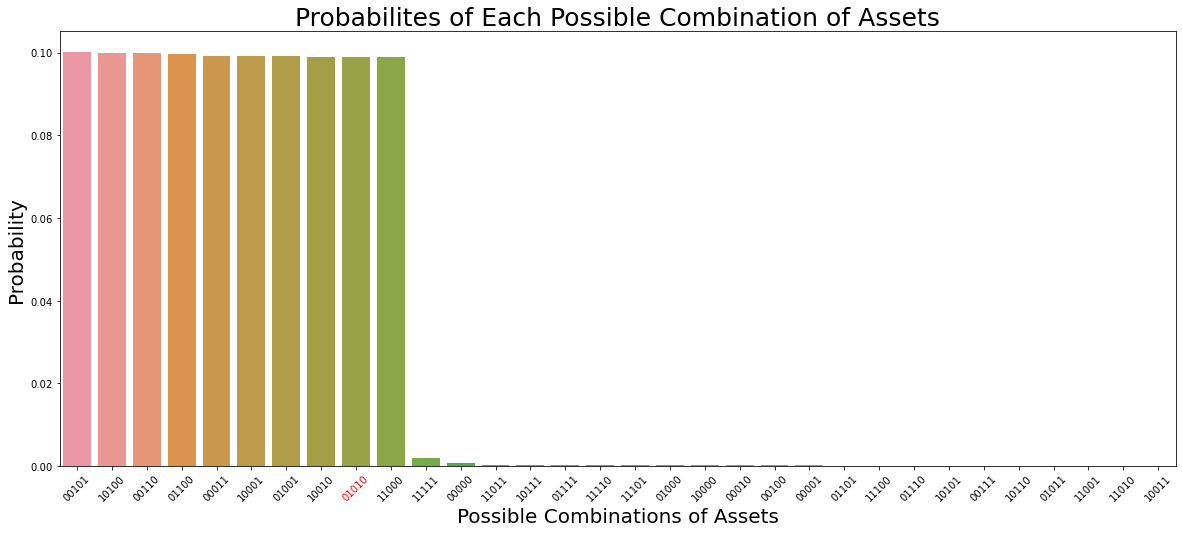

In [362]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(x=state, y=probabilities)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

### VQE

In [363]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=2500)
ry = TwoLocal(n, 'ry', 'cz', reps=3, entanglement='full')
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

selection, state, values, probabilities = print_result(result)
print(f"VQE selected:          {selection_to_picks(n, selection)}")
print(f"VQE optimal solution:  {selection}")
print(f"VQE optimal value:     {obj_val(selection)}")

Optimal: selection [0. 1. 0. 1. 0.], value -0.002649

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	-0.001946		0.951957
[0 0 1 0 1]	0.000150		0.032795
[0 1 0 0 1]	-0.002032		0.009367
[0 0 0 1 1]	-0.001905		0.005407
[0 0 0 1 0]	1.027330		0.000136
[0 1 1 0 0]	-0.000476		0.000089
[1 1 1 0 0]	1.028955		0.000074
[1 0 1 1 0]	1.029423		0.000043
[0 1 1 0 1]	1.029730		0.000036
[0 0 1 1 0]	-0.000388		0.000019
[0 1 0 0 0]	1.027792		0.000013
[1 1 0 1 0]	1.026750		0.000012
[0 1 0 1 0]	-0.002649		0.000011
[1 0 0 1 0]	-0.002643		0.000010
[1 0 1 0 0]	-0.000515		0.000007
[0 0 1 1 1]	1.030409		0.000006
[1 1 0 0 0]	-0.002560		0.000005
[0 1 1 1 0]	1.029019		0.000004
[1 1 0 0 1]	1.027620		0.000003
[0 0 1 0 0]	1.029425		0.000003
[1 1 0 1 1]	4.117001		0.000001
[0 0 0 0 0]	4.117079		0.000001
[0 0 0 0 1]	1.027773		0.000001
[0 1 0 1 1]	1.027598		0.000000
[1 1 1 1 0]	4.118202		0.000000
[1 0 1 1 1]	4.120224		0.00000

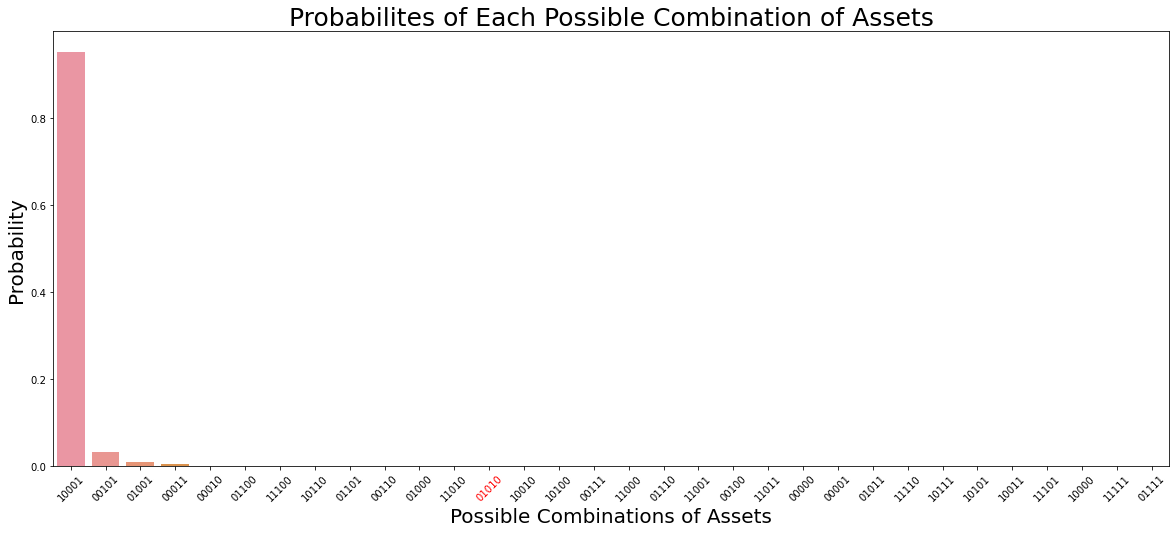

In [364]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(x=state, y=probabilities)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

### Circuit Design

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}\lambda x^TQx - (1 - \lambda)r^Tx +  P \cdot (\mathbf{1}^Tx - k) \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

Here, we set $P \approx \mathbb{E}[-\frac{k^2\lambda}{2n^2}\sum_{i=0}^n\sum_{i=0}^n q_{ij} + \frac{k(1-\lambda)}{n}\sum_{i=0}^nr_i]$
The corresponding QUBO formulation for our problem is as follows:
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & x^T \left[\frac{\lambda}{2}Q + P\mathbb{1} \mathbb{1}^T \right] x - \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^T x + C\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

#### Corresponding Ising Model

define a new variable $s$ such that $x = \frac{1-s}{2}$, so $s \in \{-1, 1\}$

$$
\begin{aligned}
& \underset{s}{\text{minimize}} & & s^T \left[\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T\right)\right]s
+ \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^Ts
+ C\\
        &&& s \in \{-1,1\}\\
\end{aligned}
$$

#### Corresponding Hamiltonian
let $J =\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T\right)$, and let $h = \frac{1}{2}(1-\lambda)r+2kP\mathbb{1}-\frac{\lambda}{4}\mathbb{1}^TQ-\frac{nP}{2}\mathbb{1}$.

We have $U(\gamma,C)=e^{\sum_{i=1}^n \sum_{j=1}^n -\frac{i\pi\gamma}{2} J_{ij}s_i s_j \sum_{i=1}^n-\frac{i\pi \gamma h_i}{2}s_i}$ $\quad$ or $\quad$ $U(\gamma,C)=\prod_{ij}e^{-\frac{i\pi\gamma}{2} J_{ij}s_i s_j} \prod_{i}e^{-\frac{i\pi \gamma }{2}h_i s_i}$

AND

$U(\beta,B)=e^{\frac{i\pi \beta}{2}B}$, where $B=\sum_{i=1}^n \sigma_x^i$ $\quad$ or $\quad$ $U(\beta,B)=\prod_{i=1}^n e^{\frac{i\pi \beta}{2}\sigma_x^i}$

In [570]:
# P = -np.sum(Q) / (2 * n**2) * k**2 * lam + k * (1 - lam) / n * np.sum(r)
# P *= 5
P = -lam/2*np.min(Q)*k**2 + (1-lam)*k*np.max(r)
J = (lam / 2 * Q + P * np.ones((n,n)))/4
h = -(1/2 * (1-lam)*r + 2*k*P*np.ones(n) - lam/4*np.ones(n).dot(Q) - n*P/2*np.ones(n))


scalar = 500
J *= scalar
h *= scalar
# J = J.astype(int)
# h = h.astype(int)

In [571]:
J

array([[0.65890944, 0.61743575, 0.64320145, 0.64116198, 0.65698296],
       [0.61743575, 0.61527858, 0.61830955, 0.61347205, 0.62430395],
       [0.64320145, 0.61830955, 0.77592847, 0.65273129, 0.65868333],
       [0.64116198, 0.61347205, 0.65273129, 0.70172517, 0.66118069],
       [0.65698296, 0.62430395, 0.65868333, 0.66118069, 0.75446969]])

In [572]:
h

array([-3.27712491, -3.33840245, -2.7314808 , -3.26399513, -3.08799316])

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/SELL
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{1}{2}\lambda x^TQx - (1 - \lambda)r^Tx +  P \cdot (\mathbf{1}^Tx - k) \cdot (\mathbf{1}^Tx - k)\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

Here, we set $P \approx \mathbb{E}[-\frac{k^2\lambda}{2n^2}\sum_{i=0}^n\sum_{i=0}^n q_{ij} + \frac{k(1-\lambda)}{n}\sum_{i=0}^nr_i]$
The corresponding QUBO formulation for our problem is as follows:
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & x^T \left[\frac{\lambda}{2}Q + P\mathbb{1} \mathbb{1}^T \right] x - \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^T x + C\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

#### Corresponding Ising Model

define a new variable $s$ such that $x = \frac{1-s}{2}$, so $s \in \{-1, 1\}$

$$
\begin{aligned}
& \underset{s}{\text{minimize}} & & (\frac{1-s}{2})^T \left[\frac{\lambda}{2}Q + P\mathbb{1} \mathbb{1}^T \right] (\frac{1-s}{2}) - \left[(1-\lambda)r + 2Pk\mathbb{1} \right]^T (\frac{1-s}{2}) + C\\
        &&& s \in \{-1,1\}\\
\end{aligned}
$$

In [509]:
# P = -np.sum(Q) / (2 * n**2) * k**2 * lam + k * (1 - lam) / n * np.sum(r)
# P *= 5
P = -lam/2*np.min(Q)*k**2 + (1-lam)*k*np.max(r)
J = (lam / 2 * Q + P * np.ones((n,n)))/4
h = -(1/2 * (1-lam)*r + 2*k*P*np.ones(n) - lam/4*np.ones(n).dot(Q) - n*P/2*np.ones(n))


In [536]:
h

array([6.55424982, 6.6768049 , 5.46296159, 6.52799026, 6.17598631])

In [528]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit import Parameter

In [529]:
%matplotlib inline

In [573]:
def get_qaoa_circuit(n,J,h, beta, gamma, measure=True):
    qc = QuantumCircuit(n)

    for i in range(n):
        # super position all states
        qc.h(i)

    for i in range(n):
        # rotate i along the x axis by beta
        qc.rx(2 * beta*h[i], i)

    for i in range(n-1):
        for j in range(i+1,n):
            # first, add CNOT gate from i to j
            # second, rotate j along the z axis by gamma
            # finally, add another CNOT gate from i to j
            qc.rzz(2 * gamma * 2*J[i][j], i, j)
        qc.barrier()
    if measure:
        # measure the state for each i
        qc.measure_all()

    return qc

def get_expected_loss(counts):
    expected_loss = 0
    total_count = sum(counts.values())
    for state in counts:
        freq      = counts[state]
        state     = [int(s) for s in state]
        obj_value = obj_val(state)
        prob      = freq / total_count
        expected_loss += prob*obj_value
    return expected_loss

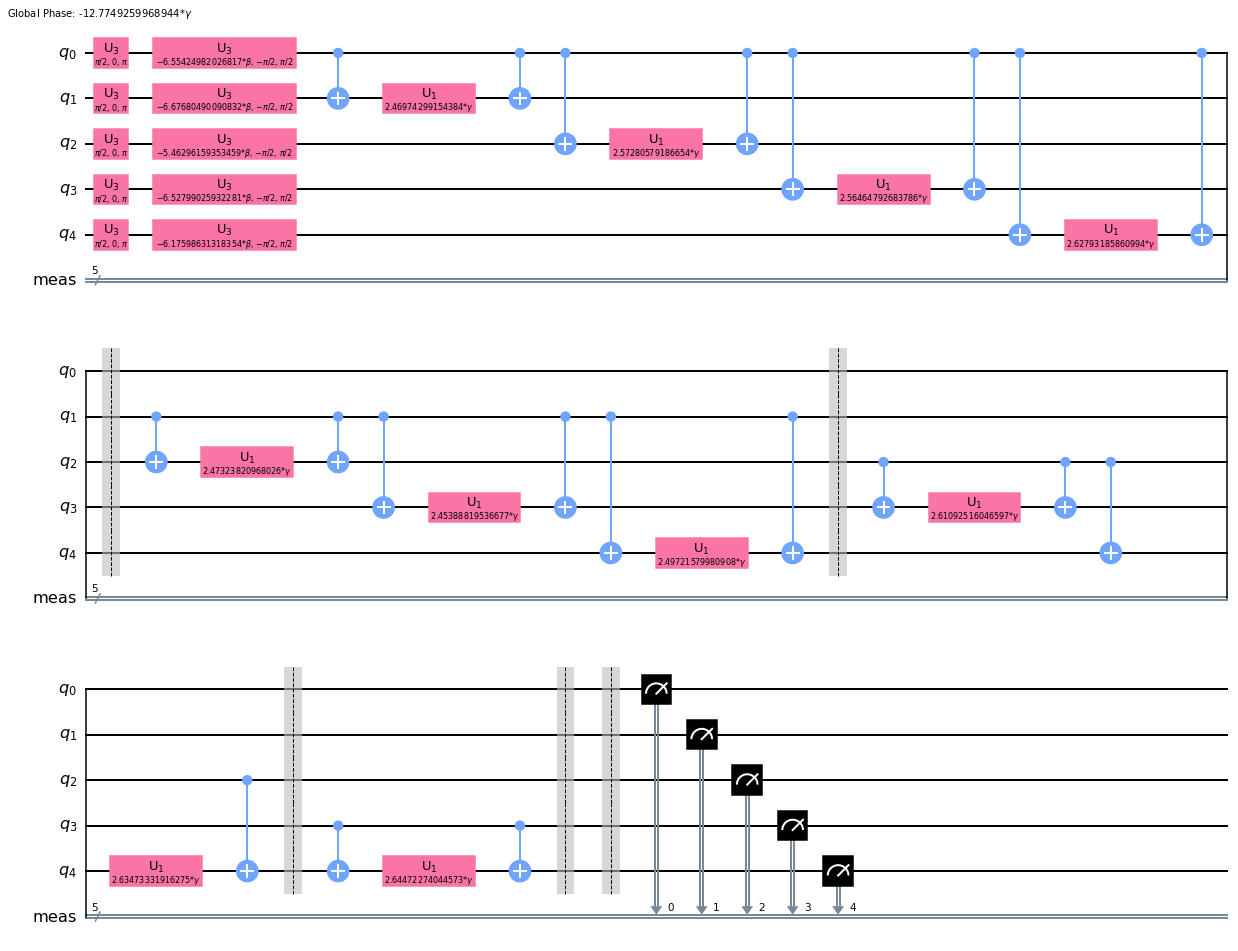

In [574]:
beta  = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")

qaoa_qc = get_qaoa_circuit(n,J,h, beta, gamma)
qaoa_qc.decompose().decompose().draw(output='mpl')

In [575]:
from qiskit.visualization import plot_state_qsphere
from qiskit.quantum_info  import Statevector

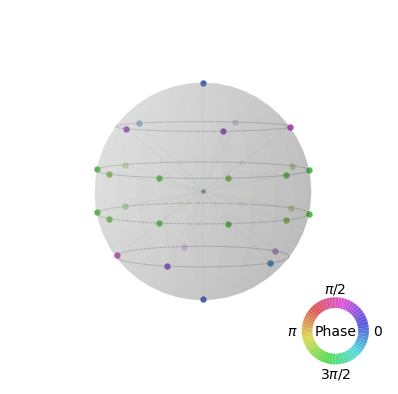

In [576]:
qaoa_qc = get_qaoa_circuit(n,J,h, np.pi/2, np.pi,measure=False)
statevec = Statevector.from_instruction(qaoa_qc).data
plot_state_qsphere(statevec,show_state_labels=False)

In [577]:
backend = Aer.get_backend("statevector_simulator")
qaoa_qc = get_qaoa_circuit(n,J,h, np.pi/2, np.pi)
job     = execute(qaoa_qc, backend, shots = 6900)
result  = job.result()
counts  = result.get_counts()
counts={k: v for k, v in sorted(counts.items(),
                                key=lambda item: item[1],
                                reverse=True)}

In [578]:

print("               ",end="")
print("  State Vector   | Objective Value | Probability |")
print("               ",end="")
print("-"*53)
total_count = sum(counts.values())
for state in counts:
    freq = counts[state]
    state = [int(s) for s in state]
    if state == gurobi:
        print_bold("Optimal ===>>> ",end=True)
    else:
        print("               ",end="")
    print((f"{state}  |"+"  ")[:20],end="")
    print(str(f"{obj_val(state):0.6f}"+"       ")[:15],end="")
    print(f"|  {freq/total_count:0.6f}   |",end="")
    if state == gurobi:
        print_bold(" <<<=== Optimal")
    else:
        print()
print("\n"*3)
print("               ",end="")
print(f"expected loss: {get_expected_loss(counts):0.6f}")

                 State Vector   | Objective Value | Probability |
               -----------------------------------------------------
               [0, 0, 1, 0, 1]  |  0.000150       |  0.034348   |
               [1, 1, 1, 1, 1]  |  0.005056       |  0.034203   |
               [0, 1, 1, 1, 0]  |  -0.000251      |  0.033913   |
               [0, 0, 1, 1, 1]  |  0.001139       |  0.033768   |
               [0, 0, 1, 1, 0]  |  -0.000388      |  0.033333   |
               [0, 1, 1, 0, 1]  |  0.000461       |  0.033188   |
               [0, 1, 1, 0, 0]  |  -0.000476      |  0.032609   |
Optimal ===>>> [0, 1, 0, 1, 0]  |  -0.002649      |  0.032609   | <<<=== Optimal
               [1, 1, 0, 0, 1]  |  -0.001650      |  0.032464   |
               [1, 0, 0, 0, 0]  |  -0.001914      |  0.032464   |
               [1, 0, 0, 1, 0]  |  -0.002643      |  0.032174   |
               [1, 1, 1, 0, 0]  |  -0.000315      |  0.032174   |
               [1, 0, 1, 1, 0]  |  0.000153       |  0.031

In [519]:
loss_dim = 20
expected_loss = np.zeros((loss_dim,loss_dim))
for _b, beta in enumerate(np.arange(0,2,2/loss_dim)):
    for _g, gamma in enumerate(np.arange(0,2,2/loss_dim)):
        qaoa_qc = get_qaoa_circuit(n, np.pi*beta/2, np.pi*gamma)
        qaoa_qc.decompose().decompose().draw(output='mpl')

        backend = Aer.get_backend("statevector_simulator")
        job     = execute(qaoa_qc, backend, shots = 2500)
        result  = job.result()
        counts  = result.get_counts()
        counts={k: v for k, v in sorted(counts.items(),
                                        key=lambda item: item[1],
                                        reverse=True)}
        expected_loss[_b][_g] = get_expected_loss(counts)

TypeError: get_qaoa_circuit() missing 2 required positional arguments: 'beta' and 'gamma'

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(expected_loss, cbar=True,cmap='plasma')
ax.set_title('Expectation value of total cost',size=20)
ax.set_xlabel(r'$\gamma \ [\pi]$',size=20)
ax.set_ylabel(r'$\beta \ [\pi]$',size=20)
text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(1)
plt.text(0,26, text, ha='left', size=12)
plt.show()

In [414]:
_b,_g = np.unravel_index(expected_loss.argmin(), expected_loss.shape)
beta, gamma = _b/20, _g/20
qaoa_qc = get_qaoa_circuit(n, np.pi*beta/2, np.pi*gamma)
qaoa_qc.decompose().decompose().draw(output='mpl')

backend = Aer.get_backend("statevector_simulator")
job     = execute(qaoa_qc, backend, shots = 2500)
result  = job.result()
counts  = result.get_counts()
counts={k: v for k, v in sorted(counts.items(),
                                key=lambda item: item[1],
                                reverse=True)}
expected_loss[_b][_g] = get_expected_loss(counts)

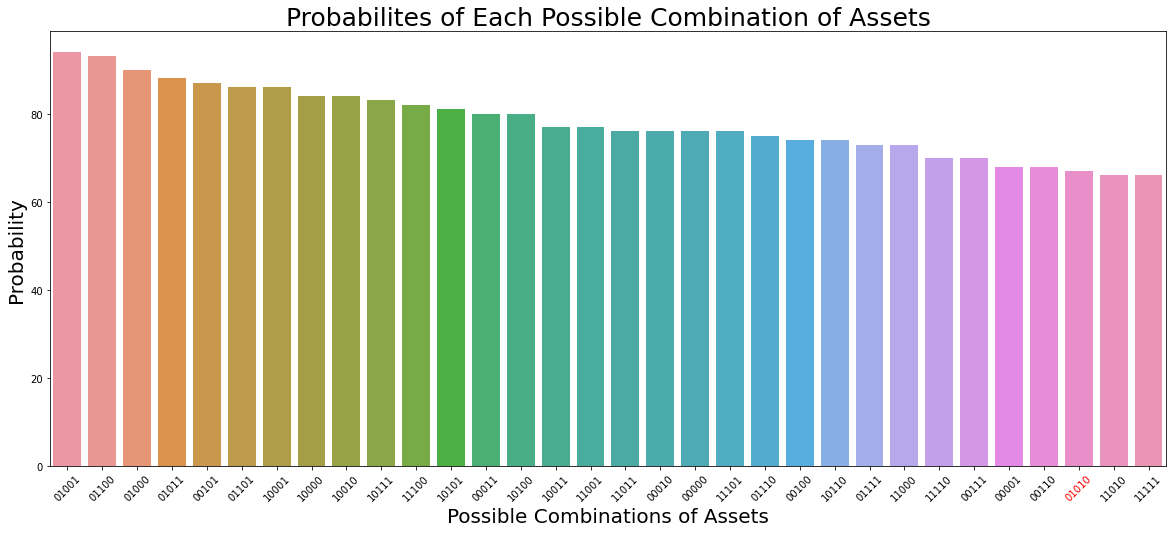

In [392]:
fig, ax = plt.subplots(figsize=(20, 8))
optimized_value = sns.barplot(x=list(counts.keys()), y=list(counts.values()))
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.get_xticklabels()
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

### k-medoids clustering for index-tracking
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & -\alpha \cdot x^TDx + \beta \cdot (1^TD) x\\
        &\text{subject to}&& \mathbf{1}^Tx = k\\
        &&& x \in \{0,1\}\\
        &\text{where}&& \alpha = \frac{1}{n-1}, \beta  = \frac{1}{k-1}
\end{aligned}
$$

In [47]:
m = Model("k-medoids")
x = {}
n = len(Q)
k = 2
beta = 1 / (2 * (k-1))
alpha = 1 / (n-1)
D = df_close_diff.corr()
D = 0.5*(1- D)
D = D.apply(np.sqrt)
D = 1 - (-0.5 * D).apply(np.exp)
D = D.values

x = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = -beta * (x @ D @ x) + alpha * (np.ones(n).dot(D) @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
gurobi   = []
for v in m.getVars():
    gurobi.append(int(v.x))
    if v.x == 1:
        selected.append(v.VarName)
print(f"Gurobi selected:         {selected}")
print(f"Gurobi optimal solution: {gurobi}")
print(f"Gurobi optimal value:    {obj_val(gurobi)}")

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x1de32f54
Model has 10 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 2e-01]
  QObjective range [3e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 0.2192381
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -3.998228e-01, 4 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   -0.39982    0    5    0.21924   -0.39982   282%     -    0s
H    0     0                       0.